<a href="https://colab.research.google.com/github/yash7125/makemore/blob/main/makemore_II_using_MLP_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
names = open('names.txt', 'r').read().splitlines()
print(names[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [126]:
chs = sorted((list(set(''.join(names)))))
print(chs)

stoi = {s:i+1 for i,s in enumerate(chs)}
stoi['.'] = 0
print(stoi)
itos = {i:s for s,i in stoi.items()}
print(itos)



['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [24]:
# import torch

# # creating our dataset
# block_size = 3
# X = []
# Y = []

# for name in names:

#   context = [0] * block_size
#   # print(name)

#   for ch in name + '.':
#     idx = stoi[ch]
#     X.append(context)
#     Y.append(idx)
#     # print(''.join(itos[i] for i in context) + '-->' + itos[idx])
#     context = context[1:] + [idx]
#     # print(context)

#   # print('\n')

# X = torch.tensor(X)
# Y = torch.tensor(Y)


In [27]:
# C = torch.randn((27, 2))

In [28]:
# emb = C[X]
# emb.shape

In [29]:
# # W1 = torch.randn((6, 100))
# # b1 = torch.randn(100)
#     # (32, 6) * (6, 100) --> (32 * 100)
# h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
# h.shape


In [30]:
# W2 = torch.randn((100, 27))
# b2 = torch.randn(27)

# logits = (h @ W2) + b2
# counts = logits.exp()

# probs = counts / counts.sum(1, keepdims=True)
# probs[0].sum()


In [31]:
# loss = -probs[torch.arange(32), Y].log().mean()
# loss

In [127]:
# making thing much more simpler and easy to read
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]


In [128]:
# creating train, val, test set

def build_dataset(names):

  X = []
  Y = []

  block_size = 3

  for name in names:

    context = [0] * block_size
    # print(name)
    for ch in name + '.':
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      # print(''.join(itos[i] for i in context) + '-->' + itos[idx])
      context = context[1:] + [idx]
      # print(context)

    # print('\n')

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, " ", Y.shape)
  return X, Y

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

random.seed(42)
random.shuffle(names)

X_train, Y_train = build_dataset(names[:n1])
val_X, val_Y =  build_dataset(names[n1 : n2])
test_X, test_Y = build_dataset(names[n2:])

torch.Size([182625, 3])   torch.Size([182625])
torch.Size([22655, 3])   torch.Size([22655])
torch.Size([22866, 3])   torch.Size([22866])


In [129]:
sum(p.nelement() for p in parameters)


11897

In [130]:
iterations = []
losses = []
lri = []

for p in parameters:
  p.requires_grad = True


In [137]:

  for i in range(200000):
    # mini-batches
    idx = torch.randint(0, X_train.shape[0], (32,))

    # implementing forward pass
    # (32, 3, 2)
    emb = C[X_train[idx]]
    # (32, 6) * (6, 100) --> (32, 100) first hidden layer
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    # second hidden layer
    logits = h @ W2 + b2
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    loss = F.cross_entropy(logits, Y_train[idx])

    # print(i + 1, " ", loss.item())

    iterations.append(i + 1)
    losses.append(loss.log10().item())

    # back propagation
    for p in parameters:
      p.grad = None
    loss.backward()

    # lr = lrs[i]
    # lri.append(lre[i])

    # print(i + 1, " ", loss.item(), " ", "lr-->", lr.item())

    lr = 0.1 if i < 100000 else 0.01
    # update the parameters
    for p in (parameters):
      p.data += -lr * p.grad

    if i % 10000 == 0:
      print(i, " ", loss.item())



0   1.974066138267517
10000   1.9950450658798218
20000   2.257275104522705
30000   2.2920565605163574
40000   2.0372071266174316
50000   2.311569929122925
60000   1.699216604232788
70000   2.032095193862915
80000   2.1077003479003906
90000   2.269979953765869
100000   2.6340060234069824
110000   2.0722177028656006
120000   2.016511917114258
130000   1.8462077379226685
140000   1.878061294555664
150000   2.027092218399048
160000   2.1043074131011963
170000   1.8046486377716064
180000   1.9252671003341675
190000   2.196657180786133


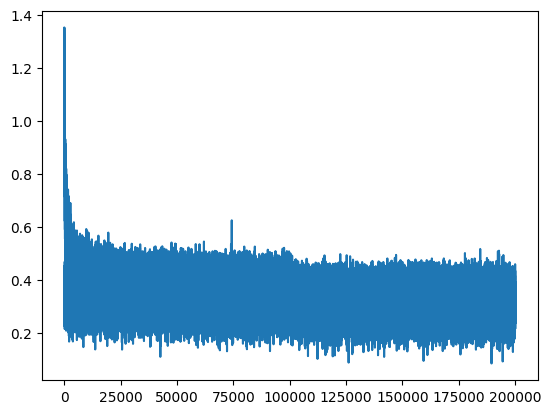

In [138]:
plt.plot(iterations[1:], losses[1:])
# # mini batches are needed
# idx = torch.randint(0, X.shape[0], (32,))
# idx
# emb = C[X]
# emb.shape
# loss

In [139]:
# train set
emb = C[X_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.0789, grad_fn=<NllLossBackward0>)

In [140]:
emb = C[val_X]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, val_Y)
loss

tensor(2.1425, grad_fn=<NllLossBackward0>)

In [141]:
emb = C[test_X]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, test_Y)
loss

tensor(2.1394, grad_fn=<NllLossBackward0>)

In [142]:
g = torch.Generator().manual_seed(2147483647)

block_size = 3

for i in range(20):

  context = [0] * block_size
  out = []
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [idx]
    if idx == 0:
      break
    out.append(idx)

  print(''.join(itos[j] for j in out))




junide
jakarie
presayven
makshir
tolette
ger
kalinaa
yaniah
hassie
ailezire
dseoniely
arteziaraulestion
maj
phynsleigh
ani
core
yarion
kaelandreedemiilmaynin
anaashraviah
mozahdan
